In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from time import time
import os

from utils import reset_seed, display_compare
reset_seed()
tf.config.experimental.get_visible_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
(x_train_full, y_train_full), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

x_train_full = 2 * np.float32(x_train_full/255.) - 1
x_test       = 2 * np.float32(x_test/255.) - 1

x_train_full = np.expand_dims(x_train_full, - 1)

# Define a Deep Convolutional GAN

In [3]:
from tensorflow.keras.layers import Dense, Flatten, Reshape, Input, BatchNormalization
from tensorflow.keras.layers import Conv2D, LeakyReLU, UpSampling2D, Activation, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.nn import leaky_relu
reset_seed()

def make_generator(latent_dim = 30):
    generator = Sequential([
        Dense(7*7*128, use_bias=False, input_shape=[latent_dim]),
        BatchNormalization(),
        LeakyReLU(),
        Reshape((7, 7, 128)),

        UpSampling2D(), 
        Conv2D(64, 5, strides=1, padding="same", use_bias=False),
        BatchNormalization(),
        LeakyReLU(),
        
        UpSampling2D(),
        Conv2D(1, 5, strides=1, padding="same", use_bias=False),
#         BatchNormalization(),
#         LeakyReLU(),
        
#         Conv2D(1, 5, strides=1, padding="same", use_bias=False),
        
        Activation('tanh')])
    return generator

def make_discriminator():
    discriminator = Sequential([
        Input(shape=[28, 28, 1]),
        
        Conv2D(64, 5, strides=(2,2), padding='same'),
        LeakyReLU(),
        Dropout(0.4),
        
        Conv2D(128, 5, strides=(2,2), padding='same'),
        LeakyReLU(),
        Dropout(0.4),
        
        Flatten(),
        Dense(1, activation="sigmoid")])
    return discriminator

In [4]:
g = make_generator()
g.summary()
d = make_discriminator()
d.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 6272)              188160    
_________________________________________________________________
batch_normalization (BatchNo (None, 6272)              25088     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 6272)              0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 128)         0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 64)        204800    
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 64)        2

## Compile the models

In [5]:
def get_compiled_GAN(latent_dim = 30):
    reset_seed()
    
    generator     = make_generator(latent_dim)
    discriminator = make_discriminator()
    gan = Sequential([generator, discriminator])
    
    # Compile the discriminator first
    discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
    
    # Compile the whole GAN
    discriminator.trainable = False
    gan.compile(loss="binary_crossentropy", optimizer="rmsprop")
    return gan

## Training

In [6]:
def train_gan(gan, dataset, n_epochs=50, log_dir=None):
    generator, discriminator = gan.layers
    latent_dim = generator.input.shape[-1]
    
    # Create file writer
    if log_dir:
        log_dir = os.path.join(log_dir, datetime.now().strftime("%m%d_%H%M%S"))
        file_writer = tf.summary.create_file_writer(log_dir)
        # Sample 10 reference points from the latent space
        fixed_z = tf.random.normal(shape=[10, latent_dim])
    
    # Initialise Metrics
    mean_gen_loss = tf.keras.metrics.Mean()
    mean_dis_loss = tf.keras.metrics.Mean()
    
        
    for epoch in range(n_epochs):
        # Start Epoch
        print("Epoch {}/{}:".format(epoch+1, n_epochs), end="")
        start = time()
        
        for x_batch in dataset:
            
            # Prepare the discriminator inputs and labels 
            batch_size = x_batch.shape[0]
            z_noise    = tf.random.normal(shape=[batch_size, latent_dim])
            gen_images = generator(z_noise)
            x_disc     = tf.concat([gen_images, x_batch], axis=0)
            y_real     = tf.ones(batch_size)
            y_fake     = tf.zeros(batch_size)
            y_disc     = tf.concat([y_fake, y_real], axis=0)

            # 1. Training the discriminator
            discriminator.trainable = True
            dis_loss = discriminator.train_on_batch(x_disc, y_disc)
            mean_dis_loss.update_state(dis_loss)

            # 2. Training the generator
            discriminator.trainable = False
            z_noise  = tf.random.normal(shape=[batch_size, latent_dim])
            gen_loss = gan.train_on_batch(z_noise, y_real)
            mean_gen_loss.update_state(gen_loss)
        
        # Collect Epoch statitistics
        gen_loss = mean_gen_loss.result()
        dis_loss = mean_dis_loss.result()
        mean_gen_loss.reset_states()
        mean_dis_loss.reset_states()
        # Print statitistics
        print(" {:.1f}s".format(time()-start), end="")
        print("\tDiscriminator Loss: {:.3f}\tGenerator Loss: {:.3f}".format(dis_loss, gen_loss))
        
        # Update Summaries
        if log_dir:
            fixed_images = generator(fixed_z)
            if tf.size(tf.shape(fixed_images)) == 3:
                fixed_images = tf.expand_dims(fixed_images, -1)
            with file_writer.as_default():
                tf.summary.scalar("gen_loss", gen_loss, step=epoch)
                tf.summary.scalar("dis_loss", dis_loss, step=epoch)
                tf.summary.image("fixed_images", fixed_images, step=epoch, max_outputs=10)

In [9]:
batch_size = 32
train_ds = tf.data.Dataset.from_tensor_slices(x_train_full)
train_ds = train_ds.shuffle(1000, seed=0).batch(batch_size, drop_remainder=True).prefetch(1)

In [10]:
reset_seed()
latent_dim = 100
gan = get_compiled_GAN(latent_dim)
train_gan(gan, train_ds, n_epochs=1)

Epoch 1/1: 43.4s	Discriminator Loss: 0.605	Generator Loss: 0.983


# Generate new images

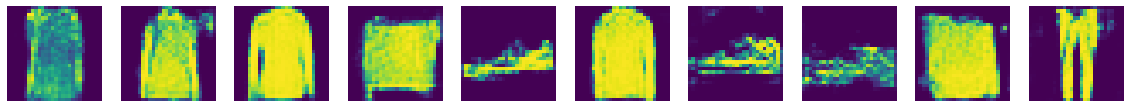

In [11]:
reset_seed()
z_noise = tf.random.normal(shape=[10, latent_dim])
generator = gan.layers[0]
fake_images = generator(z_noise)
display_compare(np.squeeze(fake_images, axis=-1))

## More training

In [15]:
reset_seed()
latent_dim = 100
gan = get_compiled_GAN(latent_dim)
train_gan(gan, train_ds, n_epochs=10, log_dir="logs/DCGAN/")

Epoch 1/10: 43.8s	Discriminator Loss: 0.633	Generator Loss: 1.052
Epoch 2/10: 42.3s	Discriminator Loss: 0.618	Generator Loss: 1.148
Epoch 3/10: 42.2s	Discriminator Loss: 0.622	Generator Loss: 1.152
Epoch 4/10: 42.3s	Discriminator Loss: 0.624	Generator Loss: 1.158
Epoch 5/10: 42.2s	Discriminator Loss: 0.631	Generator Loss: 1.142
Epoch 6/10: 42.2s	Discriminator Loss: 0.637	Generator Loss: 1.124
Epoch 7/10: 42.1s	Discriminator Loss: 0.642	Generator Loss: 1.098
Epoch 8/10: 42.1s	Discriminator Loss: 0.645	Generator Loss: 1.081
Epoch 9/10: 42.1s	Discriminator Loss: 0.650	Generator Loss: 1.066
Epoch 10/10: 42.1s	Discriminator Loss: 0.654	Generator Loss: 1.048


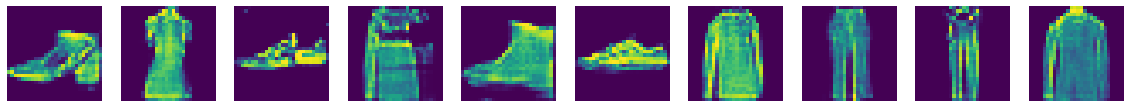

In [17]:
z_noise = tf.random.normal(shape=[10, latent_dim])
generator = gan.layers[0]
fake_images = generator(z_noise)
display_compare(np.squeeze(fake_images, axis=-1))

# Visualisation

In [22]:

low_gan = get_compiled_GAN(latent_dim=2)
train_gan(low_gan, train_ds, n_epochs=10, log_dir="logs/DCGAN/")

Epoch 1/10: 43.6s	Discriminator Loss: 0.584	Generator Loss: 1.080
Epoch 2/10: 41.9s	Discriminator Loss: 0.581	Generator Loss: 1.434
Epoch 3/10: 41.9s	Discriminator Loss: 0.547	Generator Loss: 1.641
Epoch 4/10: 41.7s	Discriminator Loss: 0.558	Generator Loss: 1.717
Epoch 5/10: 41.9s	Discriminator Loss: 0.553	Generator Loss: 1.767
Epoch 6/10: 41.7s	Discriminator Loss: 0.545	Generator Loss: 1.830
Epoch 7/10: 41.8s	Discriminator Loss: 0.546	Generator Loss: 1.842
Epoch 8/10: 41.8s	Discriminator Loss: 0.540	Generator Loss: 1.912
Epoch 9/10: 41.8s	Discriminator Loss: 0.539	Generator Loss: 1.908
Epoch 10/10: 41.7s	Discriminator Loss: 0.546	Generator Loss: 1.909


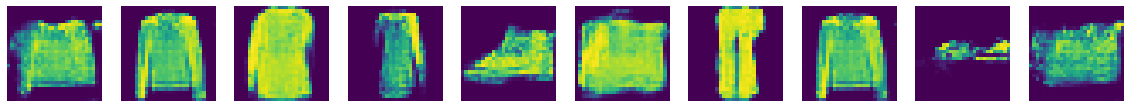

In [23]:
z_noise = tf.random.normal(shape=[10, latent_dim])
generator = low_gan.layers[0]
fake_images = generator(z_noise)
display_compare(np.squeeze(fake_images, axis=-1))

In [25]:
def get_curve(n_points=50, x_scale=1.5, y_scale=2):
    t_ = np.linspace(0,2*np.pi,n_points)
    curve_x = x_scale * np.sin(t_)
    curve_y = y_scale * np.sin(t_) * np.cos(t_)
    curve = np.vstack([curve_x, curve_y]).transpose()
    return curve

reference = np.random.normal(size=[1000, 2])
curve     = get_curve()
generator, discriminator = low_gan.layers
curve_gen = generator(curve)
curve_dis = np.squeeze(discriminator(curve_gen), -1)
curve_img = np.squeeze(curve_gen.numpy(), -1)

Done in 16.91s


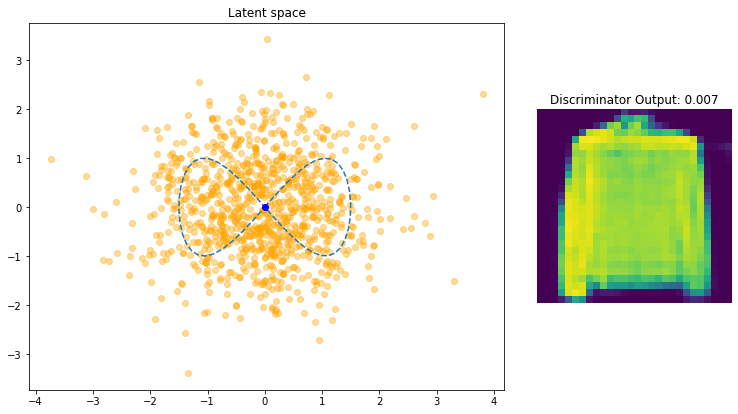

In [26]:
from time import time
from matplotlib.animation import FuncAnimation

start =time()
fig = plt.figure(figsize=(12,6))
ax = fig.add_axes([0.05, 0.05, .55, 0.85])
ax2 = fig.add_axes([.6, 0.25, 0.3, 0.45])
ax2.axis('off')
ax.set_title('Latent space')
ax.scatter(*np.hsplit(reference,2), c='orange', alpha=0.4)
ax.plot(*np.hsplit(curve,2), ls='--')


title = ax2.set_title('Discriminator Output: {:.3f}'.format(curve_dis[0]))
point, = ax.plot(*curve[0], 'bo')
img = ax2.imshow(curve_img[0])

def update(i):
    point.set_data(*curve[i])
    img = ax2.imshow(curve_img[i])
    title = ax2.set_title('Discriminator Output: {:.3f}'.format(curve_dis[i]))
    return point, img, title

anim = FuncAnimation(fig, update, frames=np.arange(len(curve)), interval=200)
anim.save('dcgan.gif', writer='imagemagick')
print("Done in %.2fs"%(time()-start))